# Covid-19 infección en Ecuador. Modelos probabilisticos

Implementacion de un modelo probabilistico de infección por el virus Covid-19

Se realiza un análisis probabilistico simple del crecimiento de la infección en Python y el modelos para comprender mejor la evolución de la infección.

Se crea modelos de series temporales del número total de personas infectadas hasta la fecha (es decir, las personas realmente infectadas más las personas que han sido infectadas). Estos modelos tienen parámetros , que se estimarán por ajuste de probabilidad.

In [1]:
# Importar las librerias para el analasis
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [10]:
# Actualizar los datos (URL)

url = 'https://covid.ourworldindata.org/data/ecdc/new_cases.csv'

df = pd.read_csv(url)
df

,date,World,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,...,Uzbekistan,Vanuatu,Vatican,Venezuela,Vietnam,Wallis and Futuna,Western Sahara,Yemen,Zambia,Zimbabwe
0,2019-12-31,27,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,2020-01-01,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,2020-01-02,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,2020-01-03,17,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,2020-01-04,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,2020-11-25,561704,185.0,744.0,1133.0,47.0,141.0,0.0,1.0,7434.0,...,192.0,0.0,0.0,355.0,4.0,0.0,0.0,7.0,12.0,90.0
331,2020-11-26,649666,200.0,644.0,1025.0,77.0,108.0,0.0,0.0,8593.0,...,188.0,0.0,0.0,319.0,5.0,1.0,0.0,10.0,69.0,110.0
332,2020-11-27,549900,0.0,656.0,1085.0,106.0,79.0,0.0,1.0,9043.0,...,182.0,0.0,0.0,0.0,10.0,0.0,0.0,13.0,18.0,115.0
333,2020-11-28,616139,214.0,645.0,NaN,76.0,NaN,0.0,0.0,7846.0,...,0.0,0.0,0.0,398.0,8.0,0.0,0.0,11.0,16.0,91.0


In [11]:
df = df.loc[:,['date','Ecuador']] #Selecciono las columnas de analasis
# Expresar las fechas en numero de dias desde el 01 Enero
FMT = '%Y-%m-%d'
date = df['date']
df['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days)
df

,date,Ecuador
0,-1,0.0
1,0,0.0
2,1,0.0
3,2,0.0
4,3,0.0
...,...,...
330,329,492.0
331,330,794.0
332,331,908.0
333,332,1396.0


<AxesSubplot:xlabel='date'>

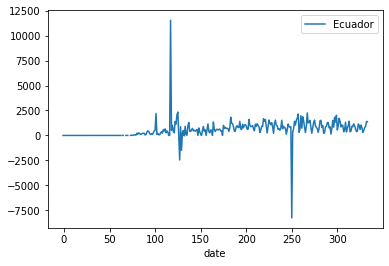

In [13]:
df.plot(x ='date', y='Ecuador')

# Modelo basado en probabilidad

Para realizar un estimacion del factor de crecimiento de los casos de Covid 19 en Ecuador calculamos la mediana, con esto obtenemo el valor medio de crecimiento de un conjunto de datos, con esto podemos obtener un factor de crecimiento o taza de crecimiento de los nuevos casos.

In [14]:

filtro = df["Ecuador"][61:] # Filtro los datos que se empezo a tener casos
#Obtenemos la mediana
media = filtro.mean()
mediana = filtro.median()
print(mediana)
print(media)

670.0
709.6988847583643


De la ecuación de la recta y = mX + b nuestra pendiente «m» es el coeficiente y el término independiente «b»

In [15]:
#Vamos a comprobar:
# según la media y la mediana podemos obtener la taza de crecieminto y predicir su comportamiento.
# Cargamos los datos de total de casos
url = 'https://covid.ourworldindata.org/data/ecdc/total_cases.csv'
df_t = pd.read_csv(url)
FMT = '%Y-%m-%d'
date = df_t['date']
df_t['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days)
df_t = df_t.loc[:,['date','Ecuador']] #Selecciono las columnas de analisis
y = list(df_t.iloc [:, 1]) # Total casos
x = list(df_t.iloc [:, 0]) # Dias
#Realizamos un ejemplo de prediccion
prediccion_siguiente = int(y[-1] + mediana)
print(prediccion_siguiente)

191579


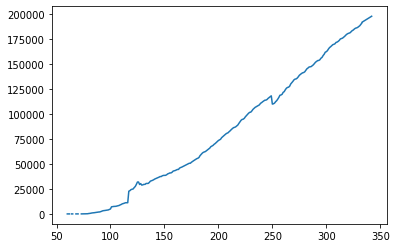

In [16]:
# Quiero predecir cuántos "Casos" voy a obtener de aqui a 10 dias.
for i in range(x[-1], x[-1]+10):
    x.append(i)
    y.append(int(y[-1] + mediana))
plt.plot(x[61:], y[61:])
plt.show()

# Practica

1. Comparar el modelo de predicion matematico vs probabilidad.
2. Retroceder un semana y comparar el modelo matematico vs probabilidad vs reales. Solo cargan los datos para generar los modelos menos 7 dias.

# Modelo Polinomial

           4           3         2
2.738e-05 x - 0.01672 x + 4.591 x + 186.9 x - 3242


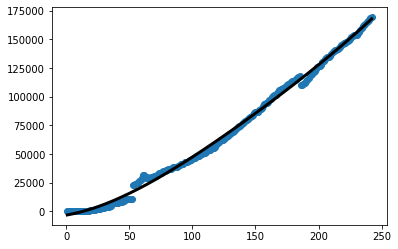

In [18]:
df = pd.read_csv('ecuador-covid-data.csv').fillna(0) # poniendo datos nan a cero
ndf= df.loc[(df['location'] == 'Ecuador') & (df['total_cases'] != 0)] # filtrando por pais y no ceros 
ndf1=ndf[['date','total_cases']]
x=np.arange(1,len(ndf1)+1,1, dtype='float') # arreglo de x lo creo para simular el numero del dia y el numero de casos
y=np.array(ndf1.values[:,1], dtype='float')

fun_pol = np.poly1d(np.polyfit(x, y, 4))
print(fun_pol)
y_pred=fun_pol(x)
plt.scatter(x, y)
plt.plot(x, y_pred, c='black',lw=3)  
plt.show()

# Modelo Probabilistico

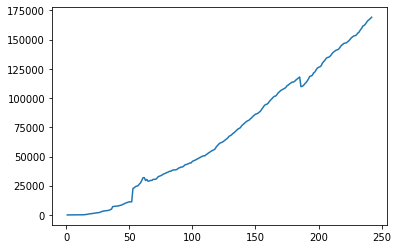

In [20]:
xp = x
yp = y

df_p = pd.read_csv('ecuador-covid-data.csv').fillna(0) # poniendo datos nan a cero
df1_p= df_p.loc[(df_p['location'] == 'Ecuador') & (df_p['total_cases'] != 0)] # filtrando por pais y no ceros 
df2_p=df1_p[['date','total_cases']]
media = df2_p.values[:,1].mean()
mediana = np.median(df2_p.values[:,1])
# Quiero predecir cuántos "Casos" voy a obtener de aqui a menos 7 dias.
for i in range(int(xp[-1]), int(xp[-1])):
    xp=np.append(xp,(i+1))
    yp=np.append(yp,yp[-1] + mediana)
#valorProbabilistico=y[319]
plt.plot(xp, yp)
plt.show()

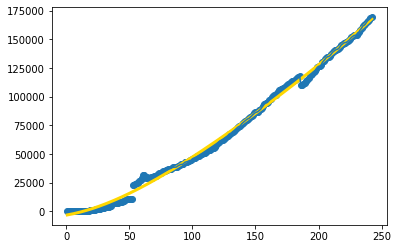

In [21]:
plt.scatter(x, y)
plt.plot(x, y_pred, c='gold',lw=3)
for i in range(int(xp[-1]), int(xp[-1])):
    xp=np.append(xp,(i+1))
    yp=np.append(yp,yp[-1] + mediana)
valorProbabilistico=yp[234]
plt.plot(xp[61:], yp[61:])
plt.show()

# Retroceder una semana para la comparacion de los modelos

In [22]:

xp_7 = xp
yp_7 = yp

for i in range(int(xp_7[-1]), int(xp_7[-1]-7)):
    xp_7=np.append(xp_7,(i+1))
    yp_7=np.append(yp_7,yp_7[-1] + mediana)
inicio = len(xp_7)-10
fin=len(xp_7)
print("Probabilistico","     ","Polinomial")
for i in range(inicio,fin):
    print(y_pred[i],"     ",round(yp_7[i],2),)
    dinin=y_pred[i]
    dfi=yp_7[i]
    real=y[i]
print("Datos Hace 7 dias: ",dinin,"    ",round(dfi,2),"     ",real)

Probabilistico       Polinomial
158729.35309380828       158270.0
159719.66631003536       159614.0
160713.67807945036       161635.0
161711.44218307146       162178.0
162713.01305903812       163192.0
163718.44580261086       164908.0
164727.79616617138       166302.0
165741.12055922273       167147.0
166758.47604838907       168192.0
167779.9203574156       169194.0
Datos Hace 7 dias:  167779.9203574156      169194.0       169194.0


# Analisis 

Al momento de analizar nuestros datos el modelo probabilistico no es el mas adecuado para hacer la prediccion debido a que realiza saltos mas grandes, mientras que el probabilistico el error es mas bajo ya que este se basa en un mediana de los datos.

# Conclusion

Se puede ver que el modelo probabilistico existen un poco mas de error debido a que los datos se presentan de manera incierta y esto hace que la predicion se vea un poco afectada. El Modelo Polinomial es el que se aproxima mas a nuestra predicion. 